# Personal portfolio
Marco Kemperman 1048504
09/01/2026

## Learning goal 2


### Connecting the BlueSky API

In the follwing code section it is shown how we connected our code to the BlueSky API. For this we created an account. You can also connect to the API without creating a BlueSky account. However, it will limit you to research only 10 keywords. As we wanted to have more we had to create an account. In our code, the handle and password are shown, but in Google Colab you could also make the secret, so that the password stays hidden for others. 

One issue we encountered during week 2 and 3 was that we got a lot of timeout 429 errors. We did not know why this happened, but when we created a new BlueSky account most of these errors were gone. Therefore, it could possibly be that there is a limit in API usage that we reached. 

In [ ]:
import requests

# Connect with BlueSky account to API
BSKY_HANDLE = "datascienceweather.bsky.social" # Fill in your own BlueSky Handle
APP_PASSWORD = "WeatherDataScience" # Add your BlueSky Password

def create_session():
    url = "https://bsky.social/xrpc/com.atproto.server.createSession"
    payload = {
        "identifier": BSKY_HANDLE,
        "password": APP_PASSWORD
    }
    r = requests.post(url, json=payload)
    r.raise_for_status()
    return r.json()["accessJwt"]

ACCESS_JWT = create_session()

### Connecting the sentiment model

In the following code section and pictures it is shown how we connected the hugging face model to our pipeline. Here it is also shown together with the picture that we used an sectet API key for the sentiment model. At first we did not have issues with API key, and we did not include this in our code. However, in week 3, we got an error stating that we should have a secret key to connect the model. 

After connection of the model, the posts are analysed in the pipeline. These posts receive a classification ranging from -1 until 1. With -1 having a completely negative sentiment about the weather, around 0 being neutral about the weather, and around 1 being positively about the weather. As it is a continous score, the sentiment score is not limited to only 3 numbers. 

In [ ]:
from google.colab import userdata # Made a secret API key in google colab
userdata.get('Weather')

# Download sentiment model and classify sentiments.
sentiment_model = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-xlm-roberta-base-sentiment",
    tokenizer="cardiffnlp/twitter-xlm-roberta-base-sentiment",
    top_k=None
)

def classify_sentiment_batch(texts, batch_size=64):
    sentiment_score = []

    for i in range(0, len(texts), batch_size):
        batch = [t[:512] for t in texts[i:i + batch_size]]
        outputs = sentiment_model(batch)

        for scores in outputs:
            score_dict = {s["label"].lower(): s["score"] for s in scores}
            sentiment = (
                score_dict.get("positive", 0.0)
                - score_dict.get("negative", 0.0)
            )
            sentiment_score.append(sentiment)

    return sentiment_score

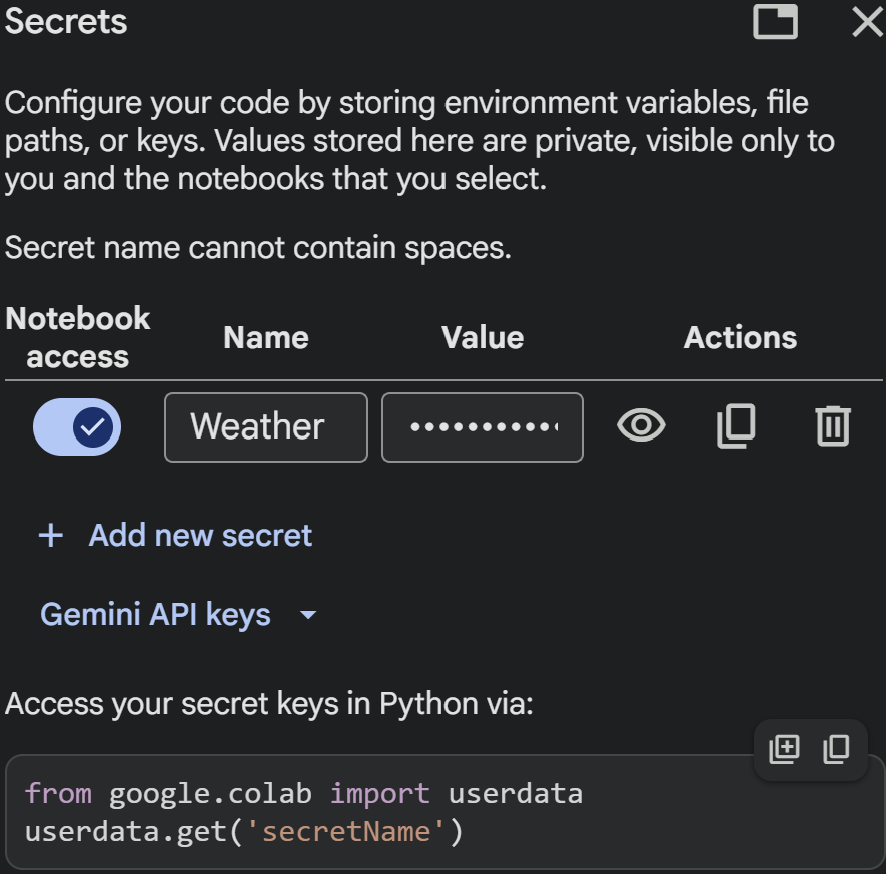


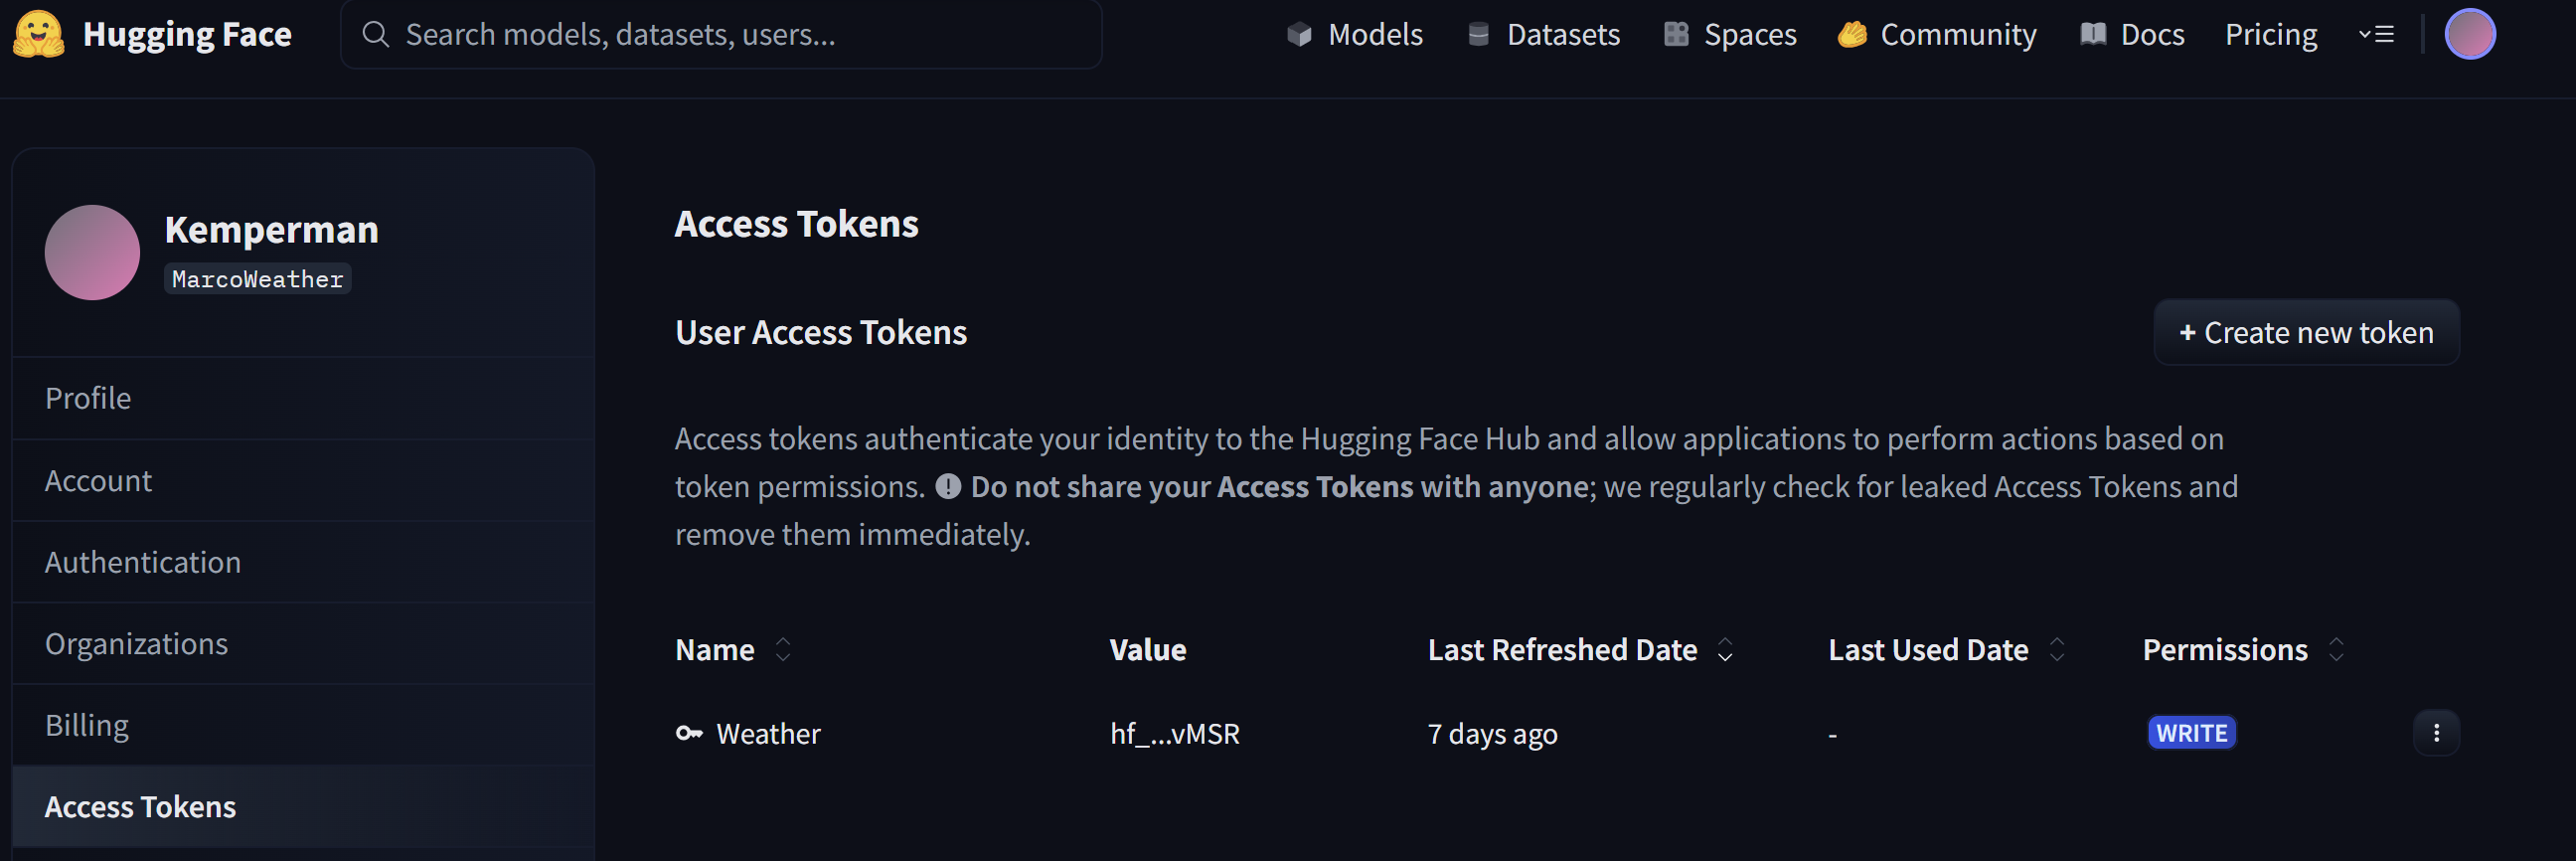


### Connecting the Meteostat

In the following section it is shown how we connected MeteoStat to our code. As you can also see this connection is done without a key. Through this code we already get the data that we need to analyse the correlation between sentiment and real weather data. 

In [ ]:
def daily_weather_for_capital(lat, lon, start, end):
    """
    Fetch daily weather data for a capital city by automatically
    selecting the nearest Meteostat station.
    """

    # Create point
    point = ms.Point(lat, lon)

    # Find nearby stations
    stations_df = ms.stations.nearby(point, limit=4)

    if stations_df.empty:
        raise ValueError("No nearby stations found")

    # Station IDs live in the index
    station_id = stations_df.index[0]

    # Fetch daily data for the selected station
    ts = ms.daily(station_id, start, end)
    df = ts.fetch()

    return df, station_id

In [ ]:
# Looping over all capitals
start = datetime(2026, 1, 1)
end   = datetime(2026, 1, 21)

all_daily = []

for country, meta in EUROPE_CAPITALS.items():
      df, station_id = daily_weather_for_capital(
          lat=meta["lat"],
          lon=meta["lon"],
          start=start,
          end=end
      )

      # Attach metadata
      df = df.copy()
      df["country"] = country
      df["capital"] = meta["city"]
      df["station_id"] = station_id

      all_daily.append(df)

# Combined DataFrame with each country
weather_daily_all = pd.concat(all_daily)
weather_daily_all = (
    weather_daily_all
        .reset_index()          # index → column named 'time'
        .rename(columns={"time": "date"})
)
weather_daily_all

## Conclusion

To conclude, connecting the different models and programs to our code was pretty easy. The most difficulties that we had was the BlueSky API, which sometimes caused timeout errors or some other errors. We fixed this mainly by creating a new BlueSky account, and by adding time.sleep features within our code pipeline